# Basic

In [1]:
!wget https://aistages-api-public-prod.s3.amazonaws.com/app/Competitions/000271/data/data.tar.gz
!tar -xf data.tar.gz

--2024-02-14 04:33:37--  https://aistages-api-public-prod.s3.amazonaws.com/app/Competitions/000271/data/data.tar.gz
Resolving aistages-api-public-prod.s3.amazonaws.com (aistages-api-public-prod.s3.amazonaws.com)... 52.219.146.63, 52.219.202.91, 52.219.202.39, ...
Connecting to aistages-api-public-prod.s3.amazonaws.com (aistages-api-public-prod.s3.amazonaws.com)|52.219.146.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33425907 (32M) [binary/octet-stream]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]  31.88M  13.2MB/s    in 2.4s    

2024-02-14 04:33:41 (13.2 MB/s) - ‘data.tar.gz’ saved [33425907/33425907]

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.app

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import time
from tqdm import tqdm

In [3]:
data_path = './data/train'

train_df = pd.read_csv(os.path.join(data_path, 'train_ratings.csv'))
year_data = pd.read_csv(os.path.join(data_path, 'years.tsv'), sep='\t')
writer_data = pd.read_csv(os.path.join(data_path, 'writers.tsv'), sep='\t') ## 한 영화에 여러 명의 극본가 유
title_data = pd.read_csv(os.path.join(data_path, 'titles.tsv'), sep='\t')
genre_data = pd.read_csv(os.path.join(data_path, 'genres.tsv'), sep='\t')  ## 한 영화가 여러 장르 유
director_data = pd.read_csv(os.path.join(data_path, 'directors.tsv'), sep='\t')  ## 한 영화에 여러 명의 감독 유

print('year : ', year_data.shape)
print('writer : ', writer_data.shape)
print('title : ', title_data.shape)
print('genre : ', genre_data.shape)
print('director : ', director_data.shape)

year :  (6799, 2)
writer :  (11306, 2)
title :  (6807, 2)
genre :  (15933, 2)
director :  (5905, 2)


# 데이터 전처리

## origin df

In [4]:
df_origin = pd.merge(title_data, year_data, on=['item'], how='outer')
df_origin = pd.merge(df_origin, writer_data, on=['item'], how='outer')
df_origin = pd.merge(df_origin, director_data, on=['item'], how='outer')
df_origin = pd.merge(df_origin, genre_data, on=['item'], how='outer')

idx = list(df_origin[df_origin['year'].isna()].index)

for i in range(df_origin.shape[0]):
  if i in idx:
    df_origin.loc[i, 'year'] = float(df_origin.loc[i, 'title'][-5:-1])

df_origin

,item,title,year,writer,director,genre
0,318,"Shawshank Redemption, The (1994)",1994.0,nm0000175,nm0001104,Crime
1,318,"Shawshank Redemption, The (1994)",1994.0,nm0000175,nm0001104,Drama
2,318,"Shawshank Redemption, The (1994)",1994.0,nm0001104,nm0001104,Crime
3,318,"Shawshank Redemption, The (1994)",1994.0,nm0001104,nm0001104,Drama
4,2571,"Matrix, The (1999)",1999.0,nm0905152,nm0905152,Action
...,...,...,...,...,...,...
37669,8605,Taxi 3 (2003),2003.0,nm0000108,nm0470443,Action
37670,8605,Taxi 3 (2003),2003.0,nm0000108,nm0470443,Comedy
37671,3689,Porky's II: The Next Day (1983),1983.0,nm0163706,nm0163706,Comedy
37672,3689,Porky's II: The Next Day (1983),1983.0,nm0650276,nm0163706,Comedy


In [5]:
df_origin.isna().sum()

item           0
title          0
year           0
writer      2367
director    4329
genre          0
dtype: int64

## df       (작가, 감독, 장르 데이터 이어붙이기)

In [6]:
writer_df = pd.DataFrame({'item':[], 'writer':[]})

for item, writer in writer_data.groupby('item')['writer'] :
  temp = pd.DataFrame({'item':[item], 'writer':[set(writer)]})
  writer_df = pd.concat([writer_df, temp], ignore_index = True)

# writer_df['writer'] = writer_df['writer'].map(lambda x: ','.join(x))

In [8]:
director_df = pd.DataFrame({'item':[], 'director':[]})

for item, director in director_data.groupby('item')['director'] :
  temp = pd.DataFrame({'item':[item], 'director':[set(director)]})
  director_df = pd.concat([director_df, temp], ignore_index = True)

# director_df['director'] = director_df['director'].map(lambda x: ','.join(x))

In [7]:
genre_df = pd.DataFrame({'item':[], 'genre':[]})

for item, genre in genre_data.groupby('item')['genre'] :
  temp = pd.DataFrame({'item':[item], 'genre':[set(genre)]})
  genre_df = pd.concat([genre_df, temp], ignore_index = True)

# genre_df['genre'] = genre_df['genre'].map(lambda x: ','.join(x))

In [9]:
df = pd.merge(title_data, year_data, on=['item'], how='outer')
df = pd.merge(df, writer_df, on=['item'], how='outer')
df = pd.merge(df, director_df, on=['item'], how='outer')
df = pd.merge(df, genre_df, on=['item'], how='outer')


idx = list(df[df['year'].isna()].index)

for i in range(df.shape[0]):
  if i in idx:
    df.loc[i, 'year'] = float(df.loc[i, 'title'][-5:-1])

df

,item,title,year,writer,director,genre
0,318,"Shawshank Redemption, The (1994)",1994.0,"{nm0001104, nm0000175}",{nm0001104},"{Crime, Drama}"
1,2571,"Matrix, The (1999)",1999.0,"{nm0905152, nm0905154}","{nm0905152, nm0905154}","{Sci-Fi, Action, Thriller}"
2,2959,Fight Club (1999),1999.0,"{nm0880243, nm0657333}",{nm0000399},"{Crime, Action, Drama, Thriller}"
3,296,Pulp Fiction (1994),1994.0,"{nm0000812, nm0000233}",{nm0000233},"{Crime, Comedy, Drama, Thriller}"
4,356,Forrest Gump (1994),1994.0,{nm0744839},{nm0000709},"{Romance, War, Comedy, Drama}"
...,...,...,...,...,...,...
6802,73106,American Pie Presents: The Book of Love (Ameri...,2009.0,"{nm0825738, nm0381221}",{nm0003289},{Comedy}
6803,109850,Need for Speed (2014),2014.0,{nm0309691},{nm0915304},"{Crime, Action, Drama}"
6804,8605,Taxi 3 (2003),2003.0,{nm0000108},{nm0470443},"{Comedy, Action}"
6805,3689,Porky's II: The Next Day (1983),1983.0,"{nm0163706, nm0650276}",{nm0163706},{Comedy}


In [10]:
df.isna().sum()

item           0
title          0
year           0
writer      1159
director    1304
genre          0
dtype: int64

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df['genre'].values)
df['genre_mlb'] = [x for x in labels]
print(mlb.classes_)
df

['Action' 'Adventure' 'Animation' 'Children' 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']


,item,title,year,writer,director,genre,genre_mlb
0,318,"Shawshank Redemption, The (1994)",1994.0,"{nm0001104, nm0000175}",{nm0001104},"{Crime, Drama}","[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,2571,"Matrix, The (1999)",1999.0,"{nm0905152, nm0905154}","{nm0905152, nm0905154}","{Sci-Fi, Action, Thriller}","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,2959,Fight Club (1999),1999.0,"{nm0880243, nm0657333}",{nm0000399},"{Crime, Action, Drama, Thriller}","[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,296,Pulp Fiction (1994),1994.0,"{nm0000812, nm0000233}",{nm0000233},"{Crime, Comedy, Drama, Thriller}","[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,356,Forrest Gump (1994),1994.0,{nm0744839},{nm0000709},"{Romance, War, Comedy, Drama}","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...,...,...,...,...
6802,73106,American Pie Presents: The Book of Love (Ameri...,2009.0,"{nm0825738, nm0381221}",{nm0003289},{Comedy},"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6803,109850,Need for Speed (2014),2014.0,{nm0309691},{nm0915304},"{Crime, Action, Drama}","[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
6804,8605,Taxi 3 (2003),2003.0,{nm0000108},{nm0470443},"{Comedy, Action}","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6805,3689,Porky's II: The Next Day (1983),1983.0,"{nm0163706, nm0650276}",{nm0163706},{Comedy},"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## fin_origin, fin (train ratings와 merge)

In [12]:
fin_origin = pd.merge(train_df, df_origin, on='item', how='left')
fin = pd.merge(train_df, df, on='item', how='left')

In [67]:
fin_origin

,user,item,time,title,year,writer,director,genre
0,11,4643,1230782529,Planet of the Apes (2001),2001.0,nm0099541,nm0000318,Action
1,11,4643,1230782529,Planet of the Apes (2001),2001.0,nm0099541,nm0000318,Adventure
2,11,4643,1230782529,Planet of the Apes (2001),2001.0,nm0099541,nm0000318,Drama
3,11,4643,1230782529,Planet of the Apes (2001),2001.0,nm0099541,nm0000318,Sci-Fi
4,11,4643,1230782529,Planet of the Apes (2001),2001.0,nm0115310,nm0000318,Action
...,...,...,...,...,...,...,...,...
48264326,138493,27311,1260209807,Batman Beyond: Return of the Joker (2000),2000.0,nm0227704,NaN,Action
48264327,138493,27311,1260209807,Batman Beyond: Return of the Joker (2000),2000.0,nm0227704,NaN,Animation
48264328,138493,27311,1260209807,Batman Beyond: Return of the Joker (2000),2000.0,nm0227704,NaN,Crime
48264329,138493,27311,1260209807,Batman Beyond: Return of the Joker (2000),2000.0,nm0227704,NaN,Sci-Fi


In [14]:
fin

,user,item,time,title,year,writer,director,genre,genre_mlb
0,11,4643,1230782529,Planet of the Apes (2001),2001.0,"{nm0742797, nm0465199, nm0115310, nm0099541}",{nm0000318},"{Sci-Fi, Action, Drama, Adventure}","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ..."
1,11,170,1230782534,Hackers (1995),1995.0,NaN,{nm0812200},"{Crime, Thriller, Action, Adventure}","[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,11,531,1230782539,"Secret Garden, The (1993)",1993.0,"{nm0122364, nm0003031}",{nm0002140},"{Children, Drama}","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,11,616,1230782542,"Aristocats, The (1970)",1970.0,"{nm0027011, nm0166307, nm0942723, nm0314788, n...",{nm0718627},"{Children, Animation}","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,11,2140,1230782563,"Dark Crystal, The (1982)",1982.0,"{nm0643973, nm0001345}","{nm0001345, nm0000568}","{Fantasy, Adventure}","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...
5154466,138493,44022,1260209449,Ice Age 2: The Meltdown (2006),2006.0,"{nm5022110, nm0841532, nm0310087}",{nm0757858},"{Animation, Children, Comedy, Adventure}","[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5154467,138493,4958,1260209482,Behind Enemy Lines (2001),2001.0,"{nm0859029, nm0672015, nm0892705, nm0859049}",{nm0601382},"{War, Action, Drama}","[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
5154468,138493,68319,1260209720,X-Men Origins: Wolverine (2009),2009.0,"{nm0940790, nm1125275}",{nm0004303},"{Sci-Fi, Action, Thriller}","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
5154469,138493,40819,1260209726,Walk the Line (2005),2005.0,"{nm0219456, nm0003506}",{nm0003506},"{Romance, Musical, Drama}","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, ..."


In [13]:
# for t in tqdm(range(fin.shape[0])):
#     fin.loc[t,'converted_time'] = time.strftime('%Y-%m', time.localtime(fin.loc[t, 'time']))

# EDA

## user

### 유저별 시청한 영화의 평균 개봉 연도

In [15]:
user_year_mean = fin.groupby('user')['year'].agg('mean')

In [140]:
user_year_mean

user
11        1997.696809
14        1986.061111
18        1995.012987
25        1991.769231
31        2005.019481
             ...     
138473    1997.333333
138475    1956.056452
138486    1992.532847
138492    1991.573529
138493    1994.095541
Name: year, Length: 31360, dtype: float64

In [62]:
user_year_mean.describe()

count    31360.000000
mean      1994.028848
std          6.417160
min       1941.492063
25%       1991.211285
50%       1994.867341
75%       1998.117011
max       2010.859649
Name: year, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7e9bb4555300>,
 'caps': [<matplotlib.lines.Line2D at 0x7e9bb4555840>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e9bb4555060>],
 'medians': [<matplotlib.lines.Line2D at 0x7e9bb4555d80>],
 'fliers': [<matplotlib.lines.Line2D at 0x7e9bb4556020>],
 'means': []}

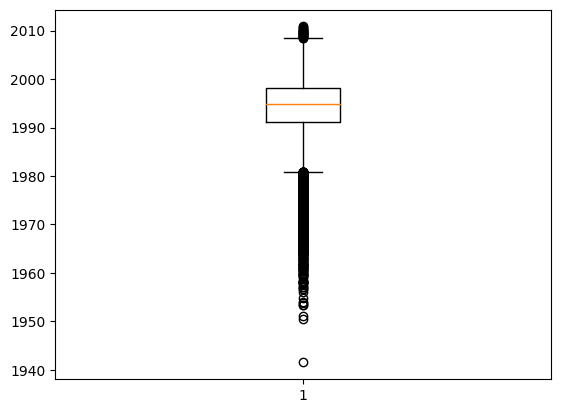

In [64]:
plt.boxplot(user_year_mean)

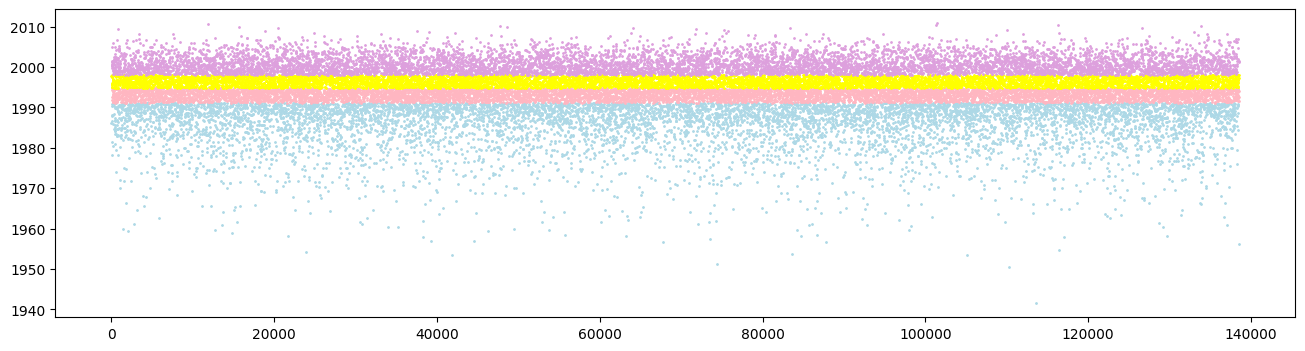

In [16]:
plt.figure(figsize=(16,4))
plt.scatter(user_year_mean.sort_values().index[:int(len(user_year_mean)*0.25)],user_year_mean.sort_values()[:int(len(user_year_mean)*0.25)], s=1, c='lightblue')
plt.scatter(user_year_mean.sort_values().index[int(len(user_year_mean)*0.25):int(len(user_year_mean)*0.5)],user_year_mean.sort_values()[int(len(user_year_mean)*0.25):int(len(user_year_mean)*0.5)], s=1, c='lightpink')
plt.scatter(user_year_mean.sort_values().index[int(len(user_year_mean)*0.5):int(len(user_year_mean)*0.75)],user_year_mean.sort_values()[int(len(user_year_mean)*0.5):int(len(user_year_mean)*0.75)], s=1, c='yellow')
plt.scatter(user_year_mean.sort_values().index[int(len(user_year_mean)*0.75):],user_year_mean.sort_values()[int(len(user_year_mean)*0.75):], s=1, c='plum')

###  유저별 선호 장르

In [104]:
genre_data['genre'].value_counts()

Drama          3490
Comedy         2408
Thriller       1466
Romance        1251
Action         1246
Crime           924
Adventure       891
Sci-Fi          653
Horror          602
Fantasy         557
Mystery         471
Children        432
Animation       355
War             346
Documentary     323
Musical         282
Western         139
Film-Noir        97
Name: genre, dtype: int64

In [138]:
user_prefer = fin_origin.groupby(['user', 'genre'])['item'].agg('count')
user_most_prefer = user_prefer.groupby(level=0).idxmax()

prefer = pd.DataFrame({'prefer_genre':[]})
prefer['prefer_genre'] = user_most_prefer.map(lambda x: x[1])
prefer

,prefer_genre
user,
11,Adventure
14,Children
18,Drama
25,Adventure
31,Adventure
...,...
138473,Drama
138475,Drama
138486,Adventure


In [98]:
prefer.value_counts()

prefer_genre
Drama           9418
Adventure       7733
Comedy          5259
Action          3899
Children        2524
Animation        775
Romance          513
Thriller         461
Fantasy          383
Sci-Fi           182
Musical           77
Crime             68
Horror            65
Film-Noir          2
War                1
dtype: int64

<BarContainer object of 18 artists>

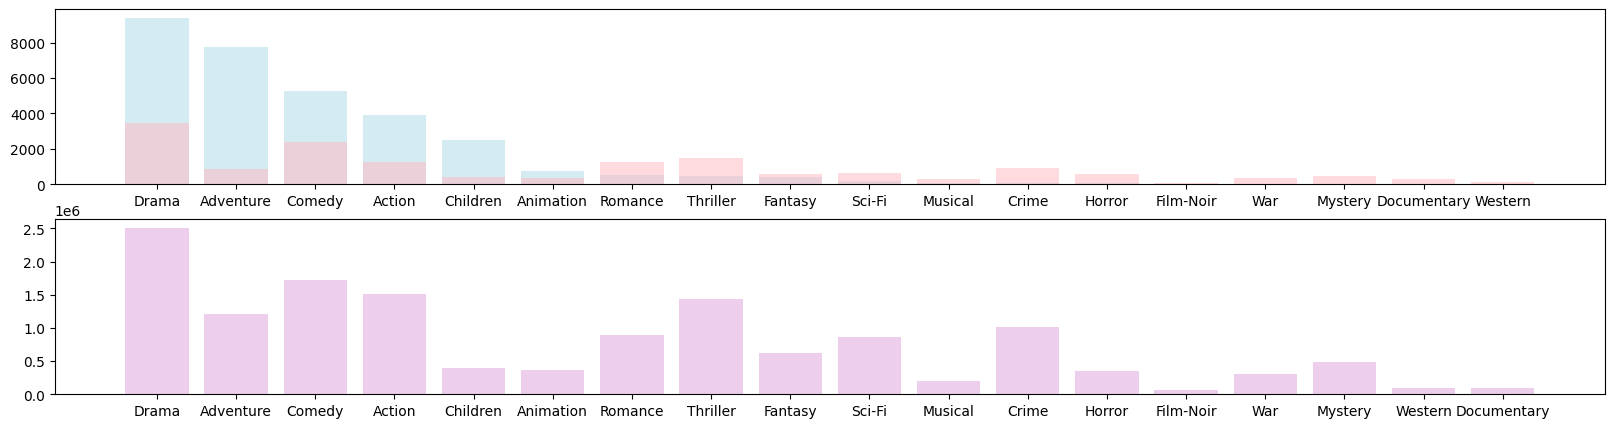

In [136]:
plt.figure(figsize=(20, 5))

## 유저가 가장 좋아하는 장르 1개
plt.subplot(211)
plt.bar(prefer['prefer_genre'].value_counts().index, prefer['prefer_genre'].value_counts().values, color='lightblue', alpha=0.5)

## 공급된 영화의 장르
plt.subplot(211)
plt.bar(genre_data['genre'].value_counts().index, genre_data['genre'].value_counts().values, color='lightpink', alpha=0.5)

## 유저가 상호작용한 영화들의 모든 장르
temp_genre = pd.merge(train_df, genre_data, on='item', how='left')
plt.subplot(212)
plt.bar(prefer['prefer_genre'].value_counts().index, prefer['prefer_genre'].value_counts().values, color='lightblue', alpha=0.5)
plt.bar(temp_genre['genre'].value_counts().index, temp_genre['genre'].value_counts().values, color='plum', alpha=0.5)

## item

### 장르 간의 상관관계

In [17]:
genre_df = pd.DataFrame({'item':[], 'genre':[]})

for item, genre in genre_data.groupby('item')['genre'] :
  temp = pd.DataFrame({'item':[item], 'genre':[set(genre)]})
  genre_df = pd.concat([genre_df, temp], ignore_index = True)

genre_df['genre'] = genre_df['genre'].map(lambda x: ','.join(x))
genre_dummies = genre_df['genre'].str.get_dummies(sep=',')

<Axes: >

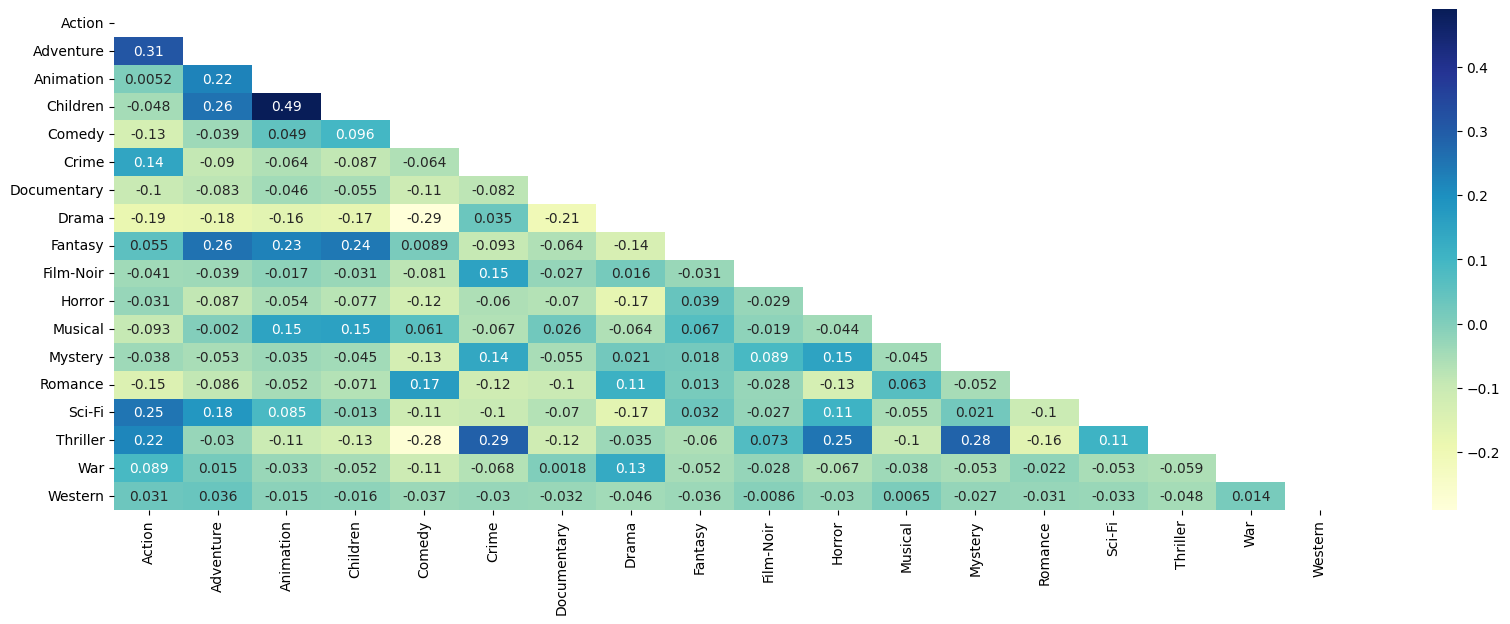

In [18]:
matrix = np.triu(genre_dummies.corr())
plt.figure(figsize=(20, 6.5))
sns.heatmap(genre_dummies.corr(), annot=True, mask=matrix, cmap='YlGnBu')

### 작가와 감독의 상관관계

In [19]:
df

,item,title,year,writer,director,genre,genre_mlb
0,318,"Shawshank Redemption, The (1994)",1994.0,"{nm0001104, nm0000175}",{nm0001104},"{Crime, Drama}","[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,2571,"Matrix, The (1999)",1999.0,"{nm0905152, nm0905154}","{nm0905152, nm0905154}","{Sci-Fi, Action, Thriller}","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,2959,Fight Club (1999),1999.0,"{nm0880243, nm0657333}",{nm0000399},"{Crime, Action, Drama, Thriller}","[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,296,Pulp Fiction (1994),1994.0,"{nm0000812, nm0000233}",{nm0000233},"{Crime, Comedy, Drama, Thriller}","[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,356,Forrest Gump (1994),1994.0,{nm0744839},{nm0000709},"{Romance, War, Comedy, Drama}","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...,...,...,...,...
6802,73106,American Pie Presents: The Book of Love (Ameri...,2009.0,"{nm0825738, nm0381221}",{nm0003289},{Comedy},"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6803,109850,Need for Speed (2014),2014.0,{nm0309691},{nm0915304},"{Crime, Action, Drama}","[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
6804,8605,Taxi 3 (2003),2003.0,{nm0000108},{nm0470443},"{Comedy, Action}","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6805,3689,Porky's II: The Next Day (1983),1983.0,"{nm0163706, nm0650276}",{nm0163706},{Comedy},"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [61]:
df[(df['writer'].isna()) | (df['director'].isna())]

,item,title,year,writer,director,genre,genre_mlb
126,590,Dances with Wolves (1990),1990.0,NaN,{nm0000126},"{Western, Drama, Adventure}","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
135,1073,Willy Wonka & the Chocolate Factory (1971),1971.0,"{nm0783544, nm0001094}",NaN,"{Fantasy, Children, Comedy, Musical}","[0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
146,1225,Amadeus (1984),1984.0,NaN,{nm0001232},{Drama},"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
167,8784,Garden State (2004),2004.0,NaN,NaN,"{Romance, Comedy, Drama}","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
202,47610,"Illusionist, The (2006)",2006.0,NaN,{nm1139726},"{Romance, Fantasy, Mystery, Drama}","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, ..."
...,...,...,...,...,...,...,...
6796,1430,Underworld (1996),1996.0,NaN,{nm0002337},"{Comedy, Thriller}","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6797,100302,Upside Down (2012),2012.0,NaN,NaN,"{Romance, Sci-Fi, Drama}","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, ..."
6800,65193,Wild Child (2008),2008.0,NaN,NaN,"{Romance, Drama}","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
6801,4219,Girls Just Want to Have Fun (1985),1985.0,NaN,{nm0582635},{Comedy},"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


- 작가 또는 감독 중 하나라도 결과가 있는 경우

    => 작가와 감독 값이 모두 있는 영화 중 반절은 작가와 감독이 같은 사람

    => 작가/감독 중 가장 첫 번째 사람을 임의로 넣는 것 어떨지

In [37]:
df_notnull = df[(df['writer'].notnull()) & (df['director'].notnull())]

cnt=0
for i in tqdm(df_notnull.index):
  if (df_notnull.loc[i,'writer'] & df_notnull.loc[i, 'director']):
    cnt+=1

print('\n')
print('count : ', cnt)
print('ratio : ', cnt/df_notnull.shape[0])

100%|██████████| 4973/4973 [00:00<00:00, 82269.15it/s]



count :  2229
ratio :  0.4482203901065755


- 작가와 감독 둘 다 없는 경우

    => 영화 데이터로만 보면 10% 가량이 없는 거지만 interaction 데이터로 보면 2%에 불과

    => others 처리

In [20]:
df[(df['writer'].isna()) & (df['director'].isna())]

,item,title,year,writer,director,genre,genre_mlb
167,8784,Garden State (2004),2004.0,NaN,NaN,"{Romance, Comedy, Drama}","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
392,2657,"Rocky Horror Picture Show, The (1975)",1975.0,NaN,NaN,"{Horror, Sci-Fi, Comedy, Musical}","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, ..."
584,55442,Persepolis (2007),2007.0,NaN,NaN,"{Drama, Animation}","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
668,7160,Monster (2003),2003.0,NaN,NaN,"{Crime, Drama}","[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
769,77455,Exit Through the Gift Shop (2010),2010.0,NaN,NaN,"{Documentary, Comedy}","[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
6777,27636,Herr Lehmann (2003),2003.0,NaN,NaN,"{Comedy, Drama}","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
6778,32302,"League of Ordinary Gentlemen, A (2004)",2004.0,NaN,NaN,{Documentary},"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6797,100302,Upside Down (2012),2012.0,NaN,NaN,"{Romance, Sci-Fi, Drama}","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, ..."
6800,65193,Wild Child (2008),2008.0,NaN,NaN,"{Romance, Drama}","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."


In [54]:
print('전체 interaction 수 : ', fin.shape[0])
print('작가, 감독 모두 없는 경우 : ', fin[(fin['writer'].isna()) & (fin['director'].isna())].groupby('item')['user'].agg('count').sort_values(ascending=False).sum())
print('비율 : ', fin[(fin['writer'].isna()) & (fin['director'].isna())].groupby('item')['user'].agg('count').sort_values(ascending=False).sum()/fin.shape[0])

전체 interaction 수 :  5154471
작가, 감독 모두 없는 경우 :  118851
비율 :  0.023057846285292904
